# Clasificación usando SIFT, K-Means y SVM

### Parte 1: Librerías y configuración inicial

In [21]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import random

#Ruta a carpeta con subcarpetas de las categorías
dataset_path = '/home/zpertupe/Documentos/Universidad/Visión Artificial/Proyecto Final/recortes_dataset'
classes = ['Torta','Telera','Reja','Rebanada','Pinguino','Oreja','Mantecada','Dona','Cuernito','Concha','Bolillo']
IMG_SIZE = (200, 200) #Tamaño al que vamos a forzar todas las imágenes
K_CLUSTERS = 150   #Valor de k para k-means

#Variables para almacenar los datos
image_paths = []
image_labels = []
all_descriptors = []
#Inicializar el SIFT
sift = cv2.SIFT_create()

### Parte 2: Carga, preoprocesamiento de imágenes y extracción de caract. locales (SIFT)

In [22]:
#función para ver kepoints detectados con SIFT
def visualizar_sift(img_path):
    #Leer imagen y hacerle resize
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, IMG_SIZE)
    #Detectar Keypoints (SIFT)
    sift_vis = cv2.SIFT_create()
    keypoints = sift_vis.detect(img, None)
    #Dibujar keypoints
    img_with_kp = cv2.drawKeypoints(img, keypoints, None, color=(0, 255, 0), flags=0)
    return img_with_kp

In [23]:
#Recorremos cada clase
for label, class_name in enumerate(classes):
    class_dir = os.path.join(dataset_path, class_name)
    if not os.path.isdir(class_dir):
        print(f"Error: Directorio {class_dir} no existe")
        continue
    print(f"{class_name}")

    for filename in os.listdir(class_dir):
        # ------ Esto es el paso 1 ------- #
        img_path = os.path.join(class_dir, filename)
        #Leer en escala de grisews
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None: continue #Omitir si no se puede leer
        #Redimensionar
        img = cv2.resize(img, IMG_SIZE)
        # ------ Esto es el paso 2 ------- #
        #Detectar puntos clave y obtener los descriptores con SIFT
        keypoints, descriptors = sift.detectAndCompute(img, None)
        if descriptors is not None:
            all_descriptors.append(descriptors)
            image_paths.append(img_path)
            image_labels.append(label)

Torta
Telera
Reja
Rebanada
Pinguino
Oreja
Mantecada
Dona
Cuernito
Concha
Bolillo


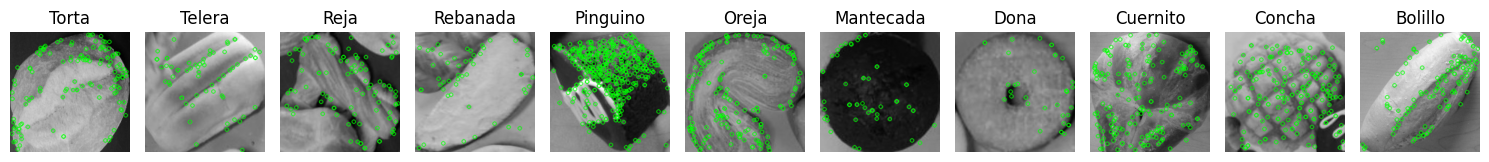

In [24]:
#Fragmento de código para generar la gráfica de los keypoints
plt.figure(figsize=(15, 11))
unique_classes = np.unique(image_labels)
for i, class_idx in enumerate(unique_classes):
    #Tomar los índices que corresponden a esta clase
    indices = np.where(np.array(image_labels) == class_idx)[0]
    if len(indices) > 0:
        sample_idx = random.choice(indices)
        sample_path = image_paths[sample_idx]
        class_name = classes[class_idx]
        #Procesar y obtener imagen
        img_result = visualizar_sift(sample_path)
        #Mostrar
        plt.subplot(1, len(unique_classes), i + 1)
        plt.imshow(img_result)
        plt.title(f"{class_name}")
        plt.axis('off')

plt.tight_layout()
plt.show()

### Paso 3: Construcción del vocabulario visual con k-means y representación de BoVW

In [25]:
#Aquí construimos el vocabulario visual con algoritmo k-means
descriptors_stack = np.vstack(all_descriptors)
kmeans = KMeans(n_clusters=K_CLUSTERS, random_state=42, n_init=10)
kmeans.fit(descriptors_stack)

#print("Completado lo primero")

#Representar cada imagen como histograma
X_features = [] #Variable donde se guardarán todos los histogramas

for i in range(len(image_paths)):
    img = cv2.imread(image_paths[i], cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, IMG_SIZE)
    kp, des = sift.detectAndCompute(img, None)
    if des is not None:
        #Predecir a qué "palabra visual" pertenece cada descriptor
        words = kmeans.predict(des)
        #Crear histograma (cuenta cuántas veces aparece cada palabra visual)
        histogram, _ = np.histogram(words, bins=K_CLUSTERS, range=(0, K_CLUSTERS))
        #Normalizar
        histogram = histogram / np.sum(histogram)
        X_features.append(histogram)

    else:
        # Si por alguna razón falla
        X_features.append(np.zeros(K_CLUSTERS))

X_features = np.array(X_features)
y_labels = np.array(image_labels)

In [ ]:
# Justo antes de graficar, guarda los datos
import numpy as np

# Guardar los datos procesados (esto es lo que más tarda en generarse)
np.save('X_features.npy', X_features)
np.save('y_labels.npy', y_labels)

# También es buena idea guardar la lista de nombres de clases
with open('classes_names.pkl', 'wb') as f:
    pickle.dump(classes, f)

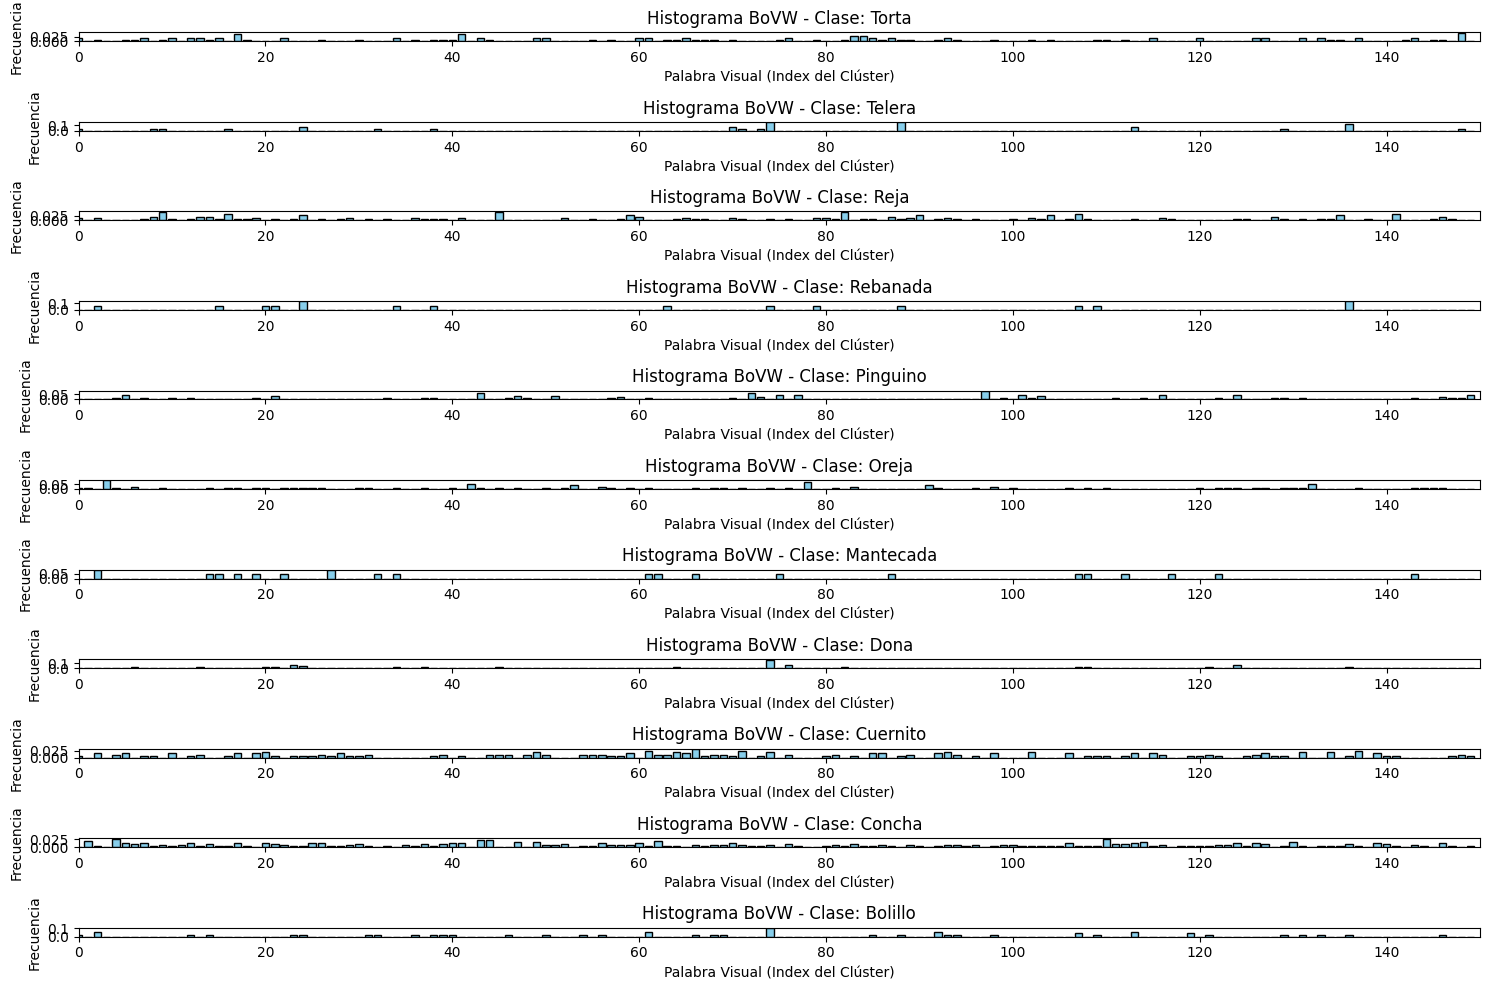

In [26]:
#Graficas de los histogramas BoVW
def plot_histograms_per_class(X, y, classes, k):
    plt.figure(figsize=(15, 10))
    unique_classes = np.unique(y)

    for i, class_idx in enumerate(unique_classes):
        indices = np.where(y == class_idx)[0]
        ind = random.choice(indices)
        example_hist = X[ind]
        plt.subplot(len(unique_classes), 1, i + 1)
        plt.bar(range(k), example_hist, color='skyblue', edgecolor='black')
        plt.title(f"Histograma BoVW - Clase: {classes[class_idx]}")
        plt.xlabel("Palabra Visual (Index del Clúster)")
        plt.ylabel("Frecuencia")
        plt.xlim(0, k)

    plt.tight_layout()
    plt.show()

# Ejecutar la función
plot_histograms_per_class(X_features, y_labels, classes, K_CLUSTERS)

### Paso 4: División de datos (entrenamiento y prueba), entrenamiento y evaluación de clasificadores

 ------------ Resultados para SVM: ---------------- 
              precision    recall  f1-score   support

       Torta       0.72      0.68      0.70       277
      Telera       0.57      0.82      0.68       286
        Reja       0.90      0.88      0.89       339
    Rebanada       0.86      0.85      0.86       283
    Pinguino       0.99      0.93      0.96       256
       Oreja       0.94      0.89      0.92       246
   Mantecada       0.78      0.82      0.80       426
        Dona       0.90      0.81      0.85       385
    Cuernito       0.83      0.78      0.81       255
      Concha       0.94      0.92      0.93       398
     Bolillo       0.80      0.73      0.76       320

    accuracy                           0.83      3471
   macro avg       0.84      0.83      0.83      3471
weighted avg       0.84      0.83      0.83      3471

Matriz de Confusión:



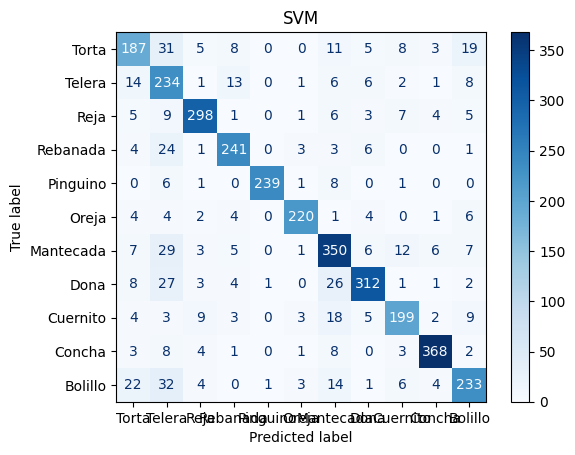

In [27]:
#División de datos 80/20
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=42)

#Clasificadores a utilizar
classifiers = {
    "SVM": SVC(kernel='rbf')
}

for name, clf in classifiers.items():
    #Entrenamiento y evaluación
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    #Impresión de los resultados
    print(f" ------------ Resultados para {name}: ---------------- ")
    print(classification_report(y_test, y_pred, target_names=classes))
    print(f"Matriz de Confusión:\n")
    disp = ConfusionMatrixDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        display_labels=classes,
        cmap=plt.cm.Blues,
        normalize=None,
    )
    disp.ax_.set_title(name)
    plt.show()

In [28]:
import pickle

with open('svm_model.pkl', 'wb') as f:
    pickle.dump(clf, f)

with open('kmeans_model.pkl', 'wb') as f:
    pickle.dump(kmeans, f)



Modelos guardados exitosamente como .pkl


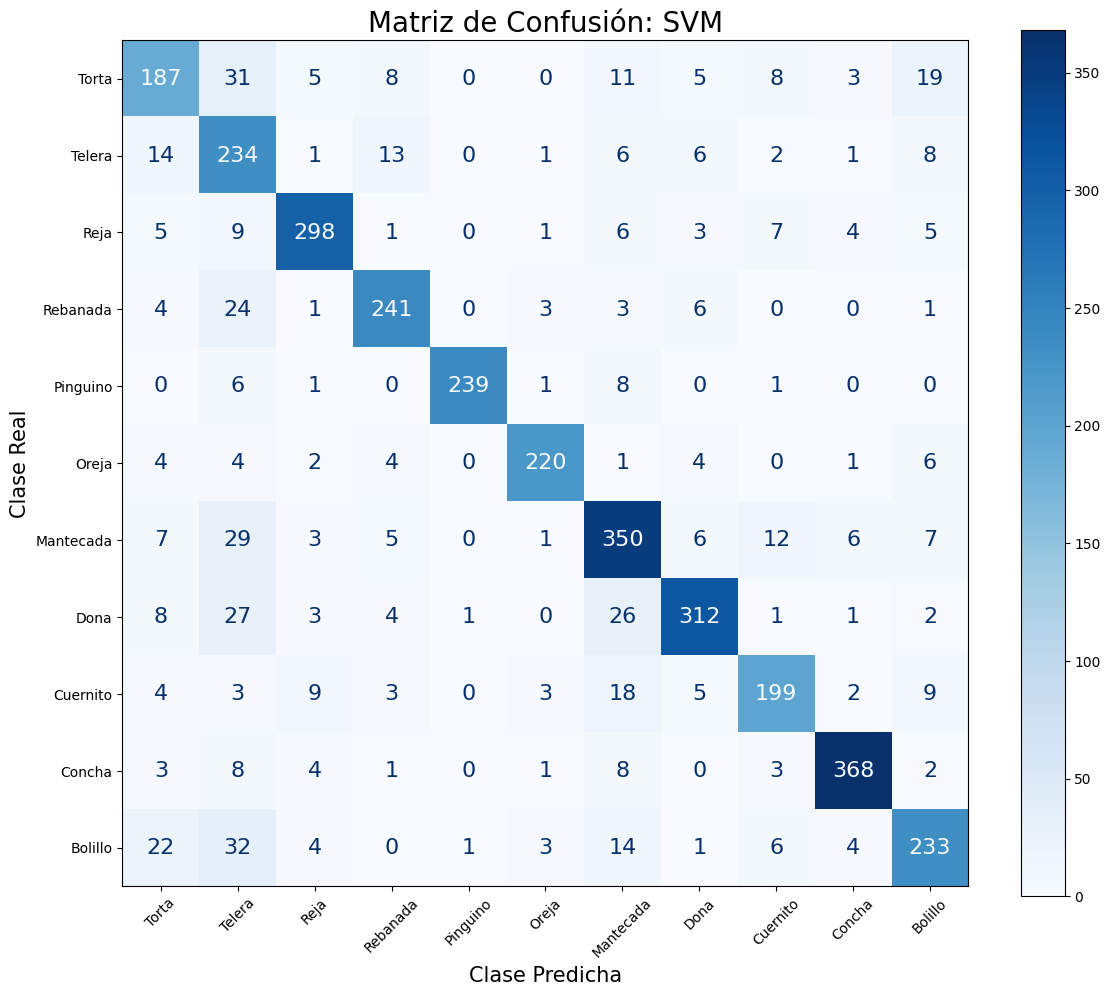

In [5]:
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Cargar datos y modelo (lo mismo de antes)
X_features = np.load('X_features.npy')
y_labels = np.load('y_labels.npy')
classes = ['Torta','Telera','Reja','Rebanada','Pinguino','Oreja','Mantecada','Dona','Cuernito','Concha','Bolillo']
svm_model = joblib.load('svm_model.pkl')

# 2. Obtener predicciones
_, X_test, _, y_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=42)
y_pred_svm = svm_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_svm)

# 3. Graficar con números grandes
fig, ax = plt.subplots(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

# Dibujamos la matriz
disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation=45)
for text in disp.text_.ravel():
    text.set_fontsize(16)

# Ajustamos también el tamaño de las etiquetas de los ejes
plt.title("Matriz de Confusión: SVM", fontsize=20)
ax.set_xlabel('Clase Predicha', fontsize=15)
ax.set_ylabel('Clase Real', fontsize=15)

plt.tight_layout()
plt.savefig('matriz_gigante.png', dpi=300)
plt.show()